In [1]:
import gym
from gym import spaces
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import cv2
import math
import copy
import pickle
import time
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import pandas as pd
import seaborn as sns 

cv2.ocl.setUseOpenCL(False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Functions 
"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
env = gym.make("Taxi-v3").env
env.render()
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/MDP', bbox_inches='tight')
plt.show()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



<Figure size 432x288 with 0 Axes>

In [ ]:
def define_action(observation_t_1,last_policy,q_table,method):

  ### Get index for the new sta
  if method=='sample':
    values=range(env.action_space.n)
    probs=list(last_policy[observation_t_1])
    action=np.random.choice(a=values,size=1,p=probs)[0]

  if method=='greedy': 
    action= np.argmax(q_table[observation_t_1])
  return action 

In [ ]:
def find_policy(q_total,theta,env):
  new_policy_table=np.full((env.observation_space.n, env.action_space.n), 1/(env.action_space.n))
  for  i in range(q_total.shape[0]):
    ### if the number is too big define a number to minus
    if (any(x>=600 for x in [theta*h for h in q_total[i]])) and not((any(x<=-600 for x in [theta*h for h in q_total[i]]))):
      num=np.max([h for h in q_total[i]])
    elif any(x<=-600 for x in [theta*h for h in q_total[i]]) and not(any(x>=600 for x in [theta*h for h in q_total[i]])):
      num=np.min([h for h in q_total[i]])
    else: 
      num=0
    total=sum([math.exp(theta*(n-num)) for n in q_total[i]])
    for j in range(q_total.shape[1]):      
      new_policy_table[i][j]=math.exp(theta*(q_total[i][j]-num))/total
  return new_policy_table


In [ ]:
def evaluate(q_table_param): 
  """Evaluate agent's performance after Q-learning"""

  total_epochs, total_penalties = 0, 0
  episodes = 100

  for _ in range(episodes):
      state = env.reset()
      epochs, penalties, reward = 0, 0, 0
      
      done = False
      
      while (not done) and (epochs<=100):
          action = np.argmax(q_table_param[state])
          state, reward, done, info = env.step(action)

          if reward == -10:
              penalties += 1

          epochs += 1

      total_penalties += penalties
      total_epochs += epochs

  print(f"Results after {episodes} episodes:")
  print(f"Average timesteps per episode: {total_epochs / episodes}")
  print(f"Average penalties per episode: {total_penalties / episodes}")

  return total_epochs / episodes

In [ ]:
def politex(alpha,gamma,theta):
  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  q_total = q_table
  policy_table= np.full((env.observation_space.n, env.action_space.n), 1/(env.action_space.n))

  %%time
  """Training the agent"""

  # For plotting metrics
  all_epochs = 0
  all_penalties = []

  for i in range(1, 50001):
      state = env.reset()
      epochs, penalties, reward, = 0, 0, 0
      done = False
      while not done:
          action = define_action(state,policy_table,q_table,'sample')

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1

      # Refresh Totals From Q  
      q_total=q_total+q_table

      # Find new policy
      policy_table=find_policy(q_total,theta,env)

      # Save the epochs
      all_epochs=all_epochs+epochs

      if i % 100 == 0:
          clear_output(wait=True)
          print(f"Episode: {i}")

          average=evaluate(q_table)
          if average<=14: 
            break

  print("Training finished.\n")
  return (i,q_table,all_epochs)

In [ ]:
### Iterates over the hyperparameters to find the best combination 
results=pd.DataFrame()
alpha_list=[]
gamma_list=[]
epsilon_list=[]
iter_list=[]
epoch_list=[]

for i in range(1,11): 
  for j in range(1,11): 
    for k in [0.001,0.005,0.01]: 
      alpha_list.append(i/10)
      gamma_list.append(j/10)
      epsilon_list.append(k)
      var_1,var_2,var_3=politex(alpha=(i/10),gamma=(j/10),theta=k)
      iter_list.append(var_1)
      epoch_list.append(var_3)

results['alpha']=alpha_list
results['gamma']=gamma_list
results['theta']=epsilon_list
results['iteration']=iter_list
results['epochs']=epoch_list


Episode: 800
Results after 100 episodes:
Average timesteps per episode: 13.92
Average penalties per episode: 0.0
Training finished.



In [3]:
### Save the results on a csv file for reproducibility 
results=pd.read_csv('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/results_politex.csv')

In [9]:
results.tail()

,Unnamed: 0,alpha,gamma,theta,iteration,epochs
295,295,1.0,0.9,0.005,500,61806
296,296,1.0,0.9,0.010,800,67957
297,297,1.0,1.0,0.001,300,146473
298,298,1.0,1.0,0.005,400,54544
299,299,1.0,1.0,0.010,800,63595


In [5]:
results[results['epochs']==results['epochs'].min()].head()

,Unnamed: 0,alpha,gamma,theta,iteration,epochs
208,208,0.7,1.0,0.005,400,52700


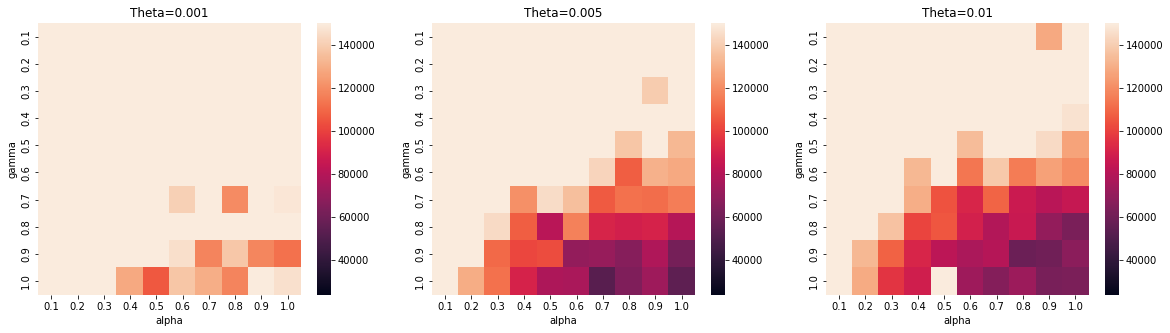

In [12]:
### Plot heatmaps with the best combination of hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
cont=1
for i,j in enumerate([0.001,0.005,0.01]): 
    cont=cont+1
    temp=results[results['theta']==j]
    temp_1=temp.pivot_table(index='gamma',columns='alpha',values='epochs',aggfunc='sum')
    axs[i].set_title('Theta='+str(j))
    sns.heatmap(temp_1,ax=axs[i],vmin=24000, vmax=150000)


plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Parameters_Politex.png', bbox_inches='tight')
plt.show()

In [7]:
### Save the results on a csv file for reproducibility 
results.to_csv('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/results_politex.csv')

In [ ]:
state = env.reset()
epochs, penalties, reward = 0, 0, 0

done = False

while not done:
    env.render()
    action = define_action(state,policy_table,q_table,'sample')
    state, reward, done, info = env.step(action)

    if reward == -10:
      penalties += 1

    epochs += 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |